In [1]:
# Setup conda activate segment
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

IMAGE_PATH = "/home/jd/segment-anything/notebooks/images/dog.jpg"
print(IMAGE_PATH, "; exist:", os.path.isfile(IMAGE_PATH))
CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

OUTPUT_DIR_PATH = "/home/jd/segment-anything/notebooks/images/seg"

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

/home/jd/segment-anything/notebooks/images/dog.jpg ; exist: True
/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True
PyTorch version: 1.13.1
Torchvision version: 0.14.1
CUDA is available: True


In [2]:
#Read image
image_sam = cv2.imread(IMAGE_PATH)
image_sam = cv2.cvtColor(image_sam, cv2.COLOR_BGR2RGB)
image_contour = image_sam.copy()
print("image_sam", len(image_sam), image_sam.shape, image_sam.dtype)

image_sam 534 (534, 800, 3) uint8


In [3]:
# Auto generate masks
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

CHECKPOINT_PATH = "/home/jd/segment-anything/models/sam_vit_h_4b8939.pth"
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))
MODEL_TYPE = "vit_h"
device = "cuda"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image_sam)

/home/jd/segment-anything/models/sam_vit_h_4b8939.pth ; exist: True


In [4]:
# Get sorted masks largest to smallest based on num_masks
num_masks=2
sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=True)[:num_masks]

In [5]:
# Get segmented masks and paint random colors in them
def make_masks(masks):
    if len(masks) == 0:
        return masks
    output_masks = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 4), dtype=float)
    output_masks[:,:,3] = 0 # mark as 100% transparent
    colors = [[1.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,1.0]]
    output_masks_list = []
    for index, mask in enumerate(sorted_masks):
        print(f"mask {index} area size {mask['area']}")
        seg = mask['segmentation']
        color_mask = np.concatenate([colors[index], [0.35]])
        output_masks_temp = output_masks.copy()
        output_masks_temp[seg] = color_mask
        output_masks_list.append(output_masks_temp)
    return output_masks_list

In [6]:
#output masks
output_masks_list = make_masks(masks)
OUTPUT_DIR_PATH = "/home/jd/segment-anything/notebooks/images/seg"
for index, output_image in enumerate(output_masks_list):
    output_image = np.uint8(output_image * 255)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGBA2BGRA)
    output_path = os.path.join(OUTPUT_DIR_PATH, f"{index}_mask.png")
    cv2.imwrite(output_path, output_image)

mask 0 area size 186556
mask 1 area size 76377


In [7]:
#Individual SAM cutouts
def make_sam_cutouts(image_sam):
    if np.issubdtype(image_sam.dtype, np.uint8):
        image_sam = image_sam / 255
    output_masks = np.ones((sorted_masks[0]['segmentation'].shape[0], sorted_masks[0]['segmentation'].shape[1], 3), dtype=float)
    #output_masks[:,:,3] = 0 # mark as 100% transparent
    sam_cutouts = []
    for index, mask in enumerate(sorted_masks):
        print(f"mask {index} area size {mask['area']}")
        seg = mask['segmentation']
        output_masks_temp = output_masks.copy()
        output_masks_temp[seg] = image_sam[seg]
        sam_cutouts.append(output_masks_temp)
    return sam_cutouts

In [8]:
#SAM cutout outputs
output_images_cuts = make_sam_cutouts(image_sam)
for index, output_image in enumerate(output_images_cuts):
    #print(output_image.dtype, output_image.shape)
    #print(output_image)
    output_image = np.uint8(output_image * 255)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    output_path = os.path.join(OUTPUT_DIR_PATH, f"{index}_sam.png")
    cv2.imwrite(output_path, output_image)

mask 0 area size 186556
mask 1 area size 76377


In [9]:
# Make SAM images 35% translucent
def make_translucent(image_sam, alpha=0.35):
    if np.issubdtype(image_sam.dtype, np.uint8):
        image_sam = image_sam / 255
    image_sam_pad = np.dstack((image_sam, np.ones((image_sam.shape[0], image_sam.shape[1]), dtype=np.uint8)))
    output_images_pad = []
    for index, mask in enumerate(sorted_masks):
        seg = mask['segmentation']
        alpha_zeroed = [tuple([x[0],x[1],x[2],alpha]) for x in image_sam_pad[seg][:,:3].tolist()]
        image_sam_pad_temp = image_sam_pad.copy()
        image_sam_pad_temp[seg] = alpha_zeroed
        output_images_pad.append(image_sam_pad_temp)
    return output_images_pad

In [10]:
#SAM outputs
output_images_pad = make_translucent(image_sam)
for index, output_image in enumerate(output_images_pad):
    output_image = np.uint8(output_image * 255)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGBA2BGRA)
    output_path = os.path.join(OUTPUT_DIR_PATH, f"{index}_seg.png")
    cv2.imwrite(output_path, output_image)

In [11]:
#Simple 50% linear alpha blending
def blend_images(image_mask, pre_merge, alpha=0.5):
    #print(image_mask, pre_merge.dtype)
    if np.issubdtype(image_mask.dtype, np.uint8):
        image_mask = image_mask / 255
    if np.issubdtype(pre_merge.dtype, np.uint8):
        pre_merge = pre_merge / 255
    merged_image = (image_mask*(1.0 - alpha)) + (pre_merge*alpha)
    return merged_image 

In [12]:
# Blended outputs
for index, (mask, output_mask, output_image) in enumerate(zip(sorted_masks, output_masks_list, output_images_pad)):
    seg = mask['segmentation']
    image_merged = output_image.copy()
    image_merged[seg] = blend_images(output_mask[seg],output_image[seg])
    image_merged = np.uint8(image_merged * 255)
    rbga_merged = cv2.cvtColor(image_merged, cv2.COLOR_RGBA2BGRA)
    output_path = os.path.join(OUTPUT_DIR_PATH, f"{index}_bln.png")
    cv2.imwrite(output_path, rbga_merged)

In [13]:
# Get masks and draw contours around them
def show_contours(masks, input_sam, num_contours=2, reverse=True):
    if len(masks) == 0:
        return
    sorted_masks = sorted(masks, key=(lambda x: x['area']), reverse=reverse) # sort masks by largest area
    output_contours = input_sam.copy()
    colors = [(255,255,0),(255,0,255),(0,255,255)]
    for index, mask in enumerate(sorted_masks):
        print(f"mask {index} area size {mask['area']}")
        mask_seg = mask['segmentation'] # Get segmentation mask
        mask_8bit = np.uint8(mask_seg * 255) # Convertion for contours
        contours = cv2.findContours(mask_8bit,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[-2]
        cv2.drawContours(output_contours,contours,-1,colors[index],3)
        if index >= num_contours: break
    return output_contours

In [14]:
def merge_image(image_mask, pre_merge, alpha=0.5, beta=0.5, gamma=0.0):
    if np.issubdtype(image_mask.dtype, np.uint8):
        image_mask = image_mask / 255
    if np.issubdtype(pre_merge.dtype, np.uint8):
        pre_merge = pre_merge / 255
    print("image_mask", image_mask.shape, image_mask.dtype)
    print("pre_merge", pre_merge.shape, pre_merge.dtype)
    merged_image = cv2.addWeighted(image_mask, alpha, pre_merge, beta, gamma)
    return merged_image

mask 0 area size 186556
mask 1 area size 76377
mask 2 area size 76223
image_mask (534, 800, 3) float64
pre_merge (534, 800, 3) float64


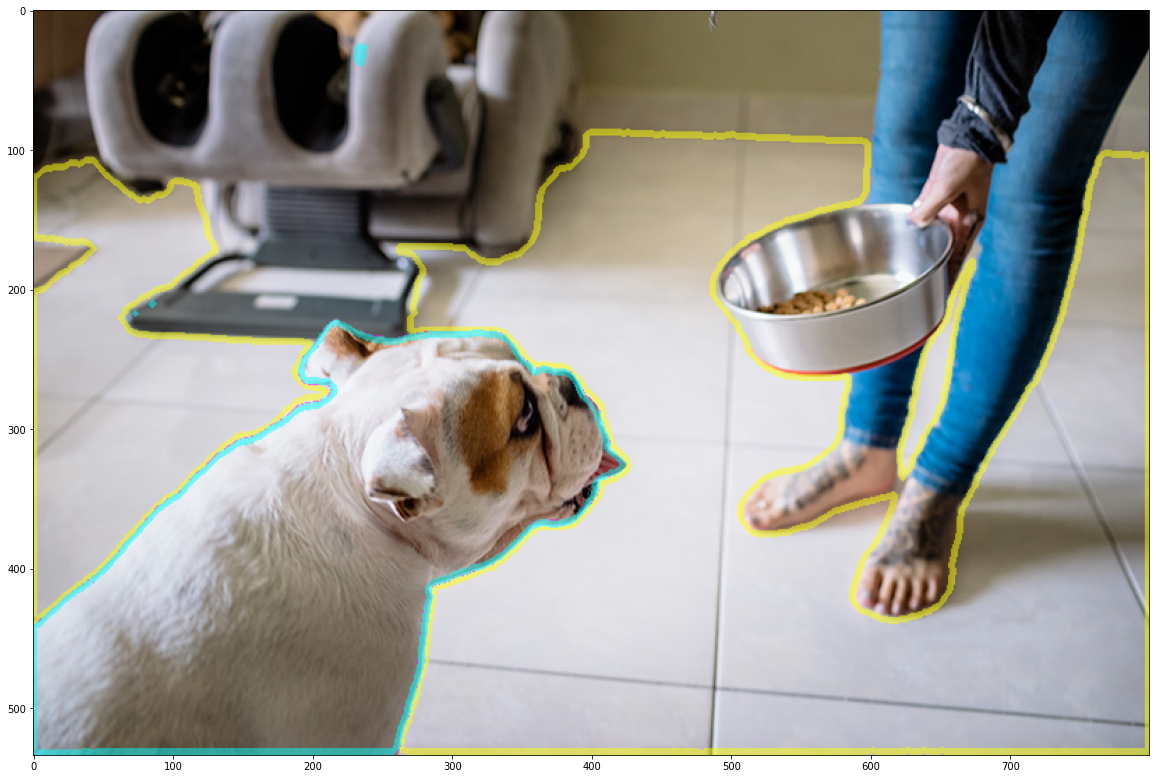

In [15]:
# Output contours
output_contours = show_contours(masks, image_contour)
merged_image_2 = merge_image(output_contours, image_contour)
plt.figure(figsize=(20,20))
plt.imshow(merged_image_2)
plt.show()
plt.close()

In [16]:
#output contours to file
merged_image_2 = np.uint8(merged_image_2 * 255)
merged_image_2 = cv2.cvtColor(merged_image_2, cv2.COLOR_RGBA2BGRA)
output_path = os.path.join(OUTPUT_DIR_PATH, "contour.png")
cv2.imwrite(output_path, merged_image_2)

True